# Cavity-Mirror

In [1]:
from math import sqrt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import numpy as np
import qutip as q
q.settings.colorblind_safe = True

import ipywidgets as widgets
from ipywidgets import GridspecLayout, interactive, Layout
from IPython.display import display

from ipynb.fs.full.Cavity_Mirror_func import plot_entropy, plot_trunc, plot_wigner_fock_cav, plot_wigner_fock_mir, plot_rabi
from ipynb.fs.full.Cavity_Mirror_func import plot_, sliders, grid_layout
from ipynb.fs.full.Cavity_Mirror_func import int_ani

%matplotlib widget
%matplotlib ipympl
%load_ext line_profiler

## Hamiltonian: Cavity-Mirror

![image.png](Img/cav-mirror.png)

In Bose et al. PRA 56, 4175 (1997), the authors consider states in cavities with a moving mirror. We can acheive different nonclassical states by letting the system evolve, using numberical simulations of the master equations using QuTiP.

$H = \omega_c a^\dagger a + \omega_m b^\dagger b - \Omega a^\dagger a (b + b^\dagger)$ 

where $\omega_c$ and $\omega_m$ are the frequencies of the cavity and mirror, and $\Omega$ is the interaction coupling.

In this example we also consider the coupling of the Jaynes-Cummings model to an external environment, i.e., we need to solve the system using the **Master Equation Solver** 'qutip.mesolve'. The coupling to the environment is described by the operators $a^\dagger, a$ and $b^\dagger, b$, annihilation and creation operators.

### Initialize
Here we define the initial state and operators for the combined system, which consists of the cavity and the atom. To the size cutoff/size of the Fock space for the mirror and cavity, therein also defining the **ladder operators** for the system. We make use of the **tensor product**, where the first part refers to the cavity and the second part to the atom.

- the **mirror** field in a coherent state $|\beta\rangle$,
- the **cavity** field in a coherent state $|\alpha\rangle$,
- a decay rate of the **mirror** of $\kappa$
- a decay rate of the **cavity** of $\gamma$,

In [2]:
# Cutoff of Fock space, 
    # might need to change values based on Hilber space truncation plot,
        # can be a puzzle to find the correct combination
    # increases run time!!!
N = 15 # Cavity
M = 50 # Mirror

In [3]:
# Ladder operations of 
    # Cavity
a = q.tensor(q.destroy(N), q.identity(M))
ad = q.tensor(q.create(N), q.identity(M))

    # Mirror
b = q.tensor(q.identity(N), q.destroy(M))
bd = q.tensor(q.identity(N), q.create(M))

In [4]:
vec = np.linspace(-7.5, 7.5, 50)
xvec, yvec = vec, vec

### Function: Master equation
Solve QED of Hamiltonian with initial state:

In [5]:
def solve_qed(om_m=2*np.pi*1, om_c=2*np.pi*1, Om=2*np.pi**1, gamma=0, kappa=0, alpha=2, beta=2, n_th_a=0, t=np.linspace(0, 2*np.pi, 100)):
    """
    Solve the cavity QED system using qutip.mesolve.

    Parameters:
    om_a  : atomic transition frequency
    om_c  : cavity resonance frequency
    Om    : vacuum Rabi frequency (coupling strength)
    gamma : atomic decay rate
    alpha : displacement of basis state in the cavity 
    beta  : displacement of basis state in the atom 
    n_th_a: avg number of thermal bath excitation
    t     : array of time values at which to evaluate the state evolution
    """

    H = om_c * ad * a + om_m * bd * b - Om/2 * ad * a * (b + bd)
    
    rho0 = q.tensor(q.coherent(N, alpha), q.coherent(M, beta))

    c_ops = []

    if gamma > 0: 
        c_ops.append(sqrt(gamma * (1 + n_th_a)) * a)
        
        if n_th_a > 0:
            c_ops.append(sqrt(gamma * n_th_a) * ad)
    
    if kappa > 0: 
        c_ops.append(sqrt(kappa * (1 + n_th_a)) * b)

        if n_th_a > 0:
            c_ops.append(sqrt(kappa * n_th_a) * bd)


    options = q.Options(store_states=True, rtol=1e-5, atol=1e-7, nsteps=10000)
    result = q.mesolve(H, rho0, t, c_ops, [], options=options)
    return result

In [6]:
result = solve_qed()
#%timeit solve_qed()

C:\Users\tobia\Desktop\Clones\SCIQIS-2025-Intro\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\tobia\Desktop\Clones\SCIQIS-2025-Intro\.venv\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


### Linear entropy
Since the dynamics here is undamped ($\alpha, \beta = 0$) the quantum state is pure, and a nonzero entropy of the subsystem demonstrates that the mirror is entangled with the cavity field. 

$S = 1-Tr(\rho_{red.}(t)^2)$, where $\rho_{red.}$ is the reduced density matrix.

The linear entropy can range between zero, corresponding to a completely pure state, and (1 − 1/d) , corresponding to a completely mixed state, where d is the dimension of the density matrix.

Notice the subsystems return to their somewhat original state at an interval.

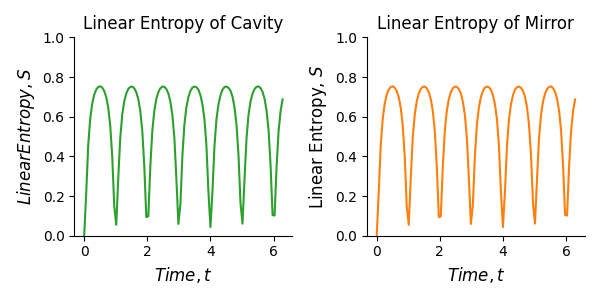

In [7]:
plot_entropy(result)

### Check Hilbert space truncation
As a check to make sure that we have use a sufficiently large Hilbert space in the calcuation above we plot the expectation value of the commutators $[a, a^\dagger]$ and $[b , b^\dagger]$ which should be very close to 1 if the Fock-state basis truncation that we used above is OK.

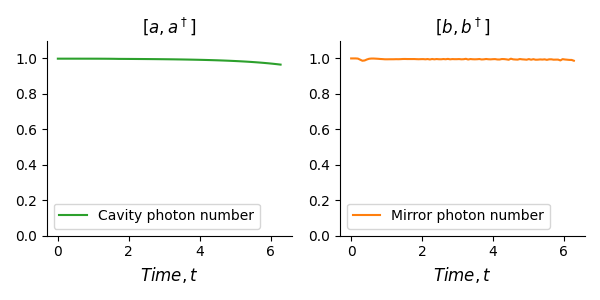

In [8]:
plot_trunc(result, a, ad, b, bd)

### Fock Distribution and Wigner function
See the time evolution of the Fock distribution and the Wigner function, notice we can generate different states.

#### Cavity
The cavity, described by negative and positive Wigner functions, therefore has a non-classical dynamics.

Depending on the value of the parameter $\Omega$ (Om), the coupling strength, the state can be made equivalent to a variety of multicomponent cats at specific times:
- $\Omega=0.5$ is a two-component Schrödinger cat
- $\Omega=1/\sqrt(6)$ is a three-component Schrödinger cat
- $\Omega=1/(2\sqrt(2))$ is a four-component Schrödinger cat

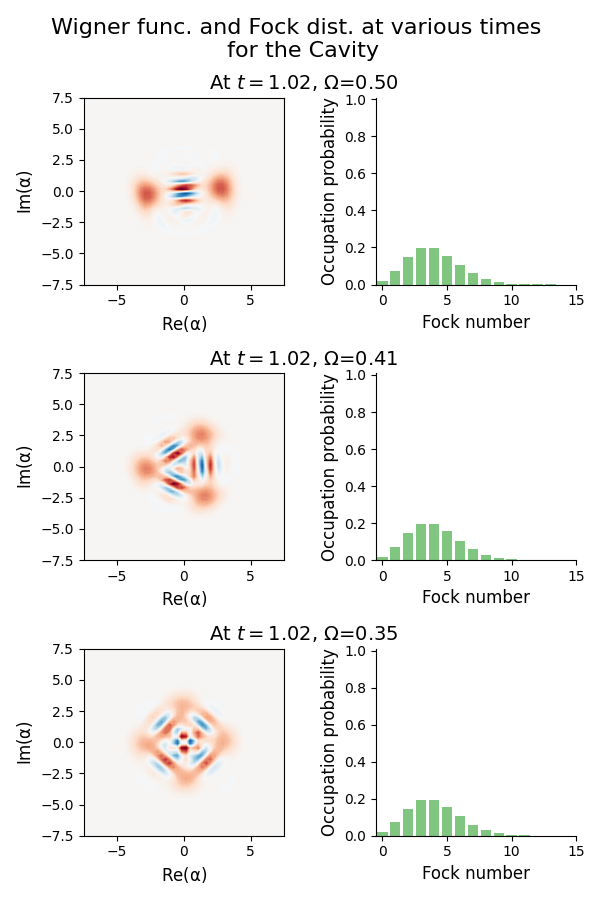

In [9]:
plot_wigner_fock_cav()

#### The Mirror
The mirror, always being in a mixture of coherent states during its evolution, is described by entirely positive Wigner functions and therefore has a fully classical
dynamics

##### Breathing
The mirror undergoes an oscillation of a different amplitude (but at the same frequency) for each number state of the field. The net effect is a kind of breathing of the mirror state; the mirror state undergoes an oscillatory increase and decrease of its position and momentum spread. However, this is very different from the well known breathing of squeezed states, as the mirror state is a mixture of coherent states.

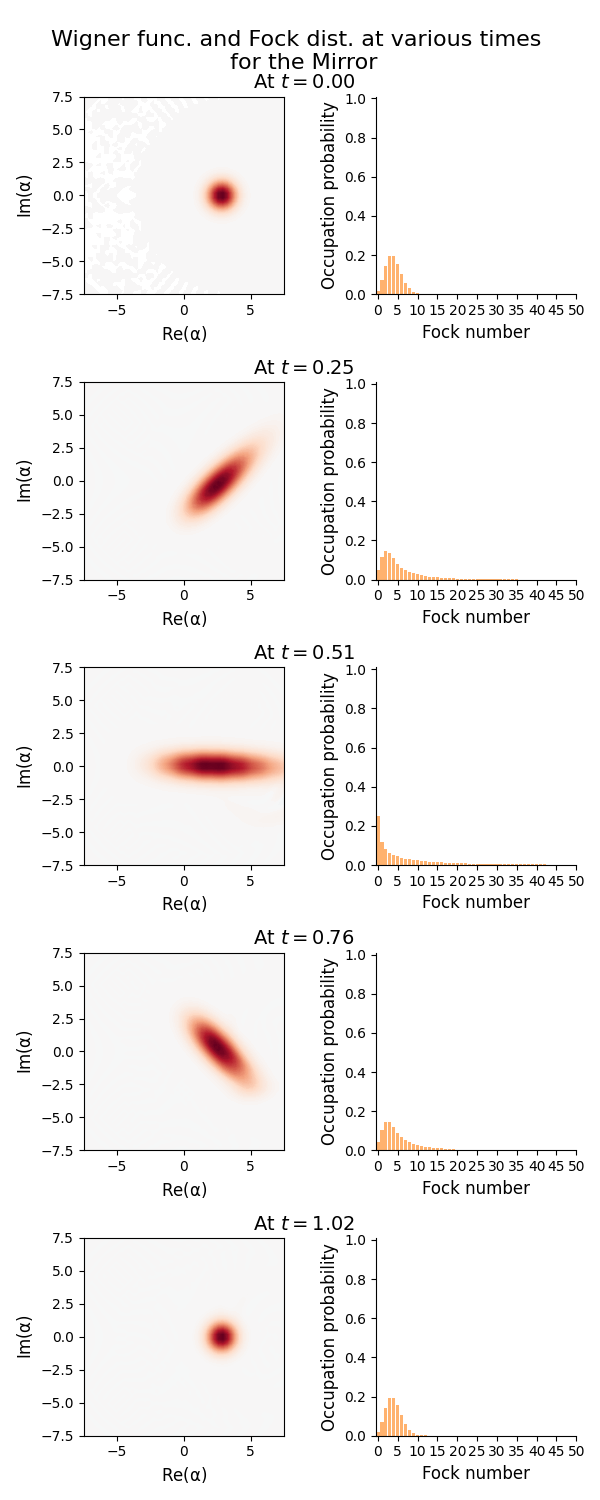

In [10]:
plot_wigner_fock_mir()

### Rabi oscillation
The excitation probabilities of the cavity and the mirror. We can clearly see how energy is being coherently transferred back and forth between the cavity and the mirror.

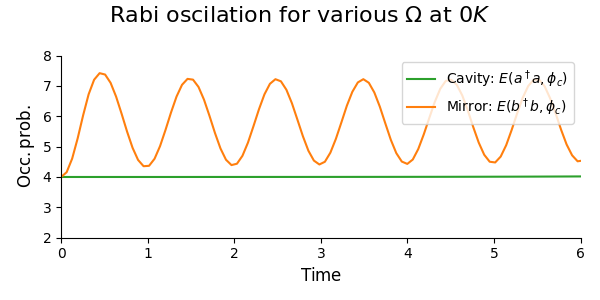

In [11]:
plot_rabi()

#### Animation
The following is the function that does the animation within the plot below.

#### Interaction
The following is the function that can be interacted with for the plot below. The sliders that can be changed to make it interactive. The grid of sliders above the plots themselvs (Note it takes a little bit before it loads the new animation/plots).

In [12]:
def plot_interactive(gamma=0, kappa=0, n_th_a=0, alpha=2, beta=2, om_m=1, om_c=1, Om=1):
    """
    Function for interactively plotting

    Parameters:
    om_m  : mirror transition frequency
    om_c  : cavity resonance frequency
    Om    : Rabi frequency (coupling strength)
    gamma : cavity decay rate
    kappa : mirror decay rate
    alpha : amplitude of the initial coherent state of the cavity 
    beta  : amplitude of the initial coherent state of the mirror 
    n_th_a: avg number of thermal bath excitation
    """

    # Adjust values for QED
    om_m = 2*np.pi * om_m   
    om_c = 2*np.pi * om_c    
    Om = 2*np.pi * Om        
    gamma = gamma/1        
    kappa = kappa/10  
    
    result = solve_qed(om_m, om_c, Om, gamma, kappa, alpha, beta, n_th_a)
    
    global xvec, yvec 
    fig, ani = plot_(result, xvec, yvec, n_th_a, alpha, beta, method='clenshaw', # projection='2d',
                            g=np.sqrt(2), sparse=False, parfor=True,
                            cmap='RdBu_r', colorbar=True, fig=None, ax=None)

    return fig, ani

In [15]:
int_ani(N, M)

GridspecLayout(children=(FloatSlider(value=0.0, continuous_update=False, description='gamma:', layout=Layout(g…

Output()

Keep things as they start up in the interactive interface, i note here how few changes shos different things:

- At coupling strength $\Omega=0.41$, notice the earliere statement of time $t$ the cat state formed is different (t=1 vs 4), futher the one higher state forms at $t=3$ and the one lower at $t=6$. (Note, $0.41 \neq 1/\sqrt(6) $)

- At coupling strength $\Omega=0.35$, notice the earliere statement of time $t$ the cat state formed is different (t=1 vs 4), we dont see any other cat state. (Note, $0.41 \neq 1/(2\sqrt(2)) $)

In [16]:
plot_bloch_trajectory(result)